In [118]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yahoofinancials import YahooFinancials
%matplotlib inline
import mpld3
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
mpld3.enable_notebook()

In [120]:
end_date = datetime.today()
start_date = end_date - timedelta(days=15 * 365)
ticker = 'A17U.SI'
stock_df = yf.download(ticker, start=start_date, end=end_date)
stock_df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI
Date,,,,,,
2009-11-18 00:00:00+00:00,0.764593,1.806241,1.816005,1.767187,1.786714,8635250
2009-11-19 00:00:00+00:00,0.760460,1.796478,1.825768,1.796478,1.806241,3699504
2009-11-20 00:00:00+00:00,0.764593,1.806241,1.816005,1.776951,1.786714,3940198
2009-11-23 00:00:00+00:00,0.776992,1.835532,1.855058,1.806241,1.816005,4672519
2009-11-24 00:00:00+00:00,0.797656,1.884349,1.894112,1.845295,1.845295,10950002


In [122]:
df=stock_df
# create 20 days simple moving average column
df['Fast_SMA'] = df['Close'].rolling(window = 20, min_periods = 1).mean()
# create 50 days simple moving average column
df['Slow_SMA'] = df['Close'].rolling(window = 100, min_periods = 1).mean()
# display first few rows
df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Fast_SMA,Slow_SMA
Ticker,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,,
Date,,,,,,,,
2009-11-18 00:00:00+00:00,0.764593,1.806241,1.816005,1.767187,1.786714,8635250,1.806241,1.806241
2009-11-19 00:00:00+00:00,0.760460,1.796478,1.825768,1.796478,1.806241,3699504,1.801360,1.801360
2009-11-20 00:00:00+00:00,0.764593,1.806241,1.816005,1.776951,1.786714,3940198,1.802987,1.802987
2009-11-23 00:00:00+00:00,0.776992,1.835532,1.855058,1.806241,1.816005,4672519,1.811123,1.811123
2009-11-24 00:00:00+00:00,0.797656,1.884349,1.894112,1.845295,1.845295,10950002,1.825768,1.825768


In [50]:
df[('Baseline_Prediction', '')] = df[('Close', 'A17U.SI')].shift(1)

In [52]:
if 'Baseline_Prediction' in df.columns:
    print("Baseline_Prediction column created successfully.")
else:
    print("Error: Baseline_Prediction column not found.")


Baseline_Prediction column created successfully.


In [56]:
df = df[df[('Baseline_Prediction', '')].notna()]

C:\Users\User\AppData\Local\Temp\ipykernel_20704\3553673141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[('Baseline_Prediction', '')] = df[('Close', 'A17U.SI')].shift(1)  # Tomorrow's prediction as today's price
C:\Users\User\AppData\Local\Temp\ipykernel_20704\3553673141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[('Baseline_Trade', '')] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_20704\3553673141.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

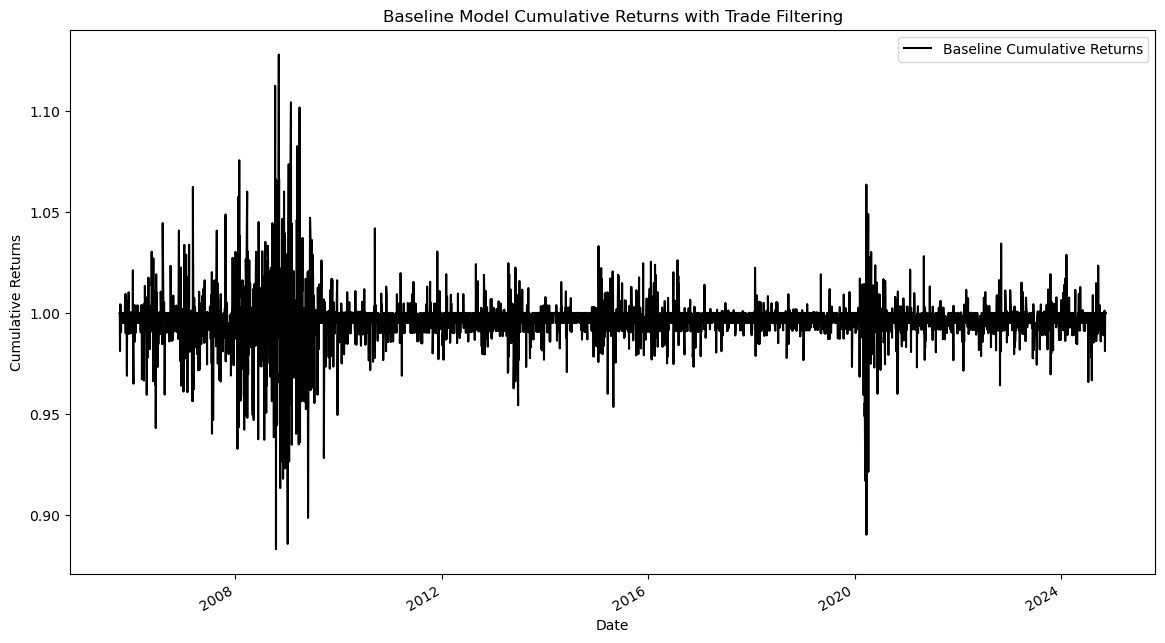

In [68]:
df[('Baseline_Prediction', '')] = df[('Close', 'A17U.SI')].shift(1)  # Tomorrow's prediction as today's price
df[('Baseline_Trade', '')] = 0

# Buy if predicted price is higher than today’s close
df.loc[df[('Baseline_Prediction', '')] > df[('Close', 'A17U.SI')], ('Baseline_Trade', '')] = 1
# Sell if predicted price is lower than today’s close
df.loc[df[('Baseline_Prediction', '')] < df[('Close', 'A17U.SI')], ('Baseline_Trade', '')] = -1

# Step 2: Apply Filtering to Avoid Frequent Trades
# Use the same threshold logic to reduce trades around similar prices
threshold = 0.01  # Set a threshold (e.g., 1%) to avoid small changes
df[('Price_Change', '')] = df[('Close', 'A17U.SI')].diff()  # Calculate daily price change

# Only update the trade signal if the price change exceeds the threshold
df[('Filtered_Trade', '')] = np.where(df[('Price_Change', '')].abs() > threshold, df[('Baseline_Trade', '')], 0)

# Step 3: Define and Apply Returns Calculation Function
def computereturns(tdf, trate):
    prevrow = tdf.iloc[0]
    returncol = tdf.columns.get_loc(('Returns', ''))
    for i in range(1, len(tdf)):
        row = tdf.iloc[i]
        rt = (row[('Close', 'A17U.SI')] / prevrow[('Close', 'A17U.SI')]) - 1
        t = prevrow[('Returns', '')] * (1 + prevrow[('Filtered_Trade', '')] * rt) * (1 - trate * abs(row[('Filtered_Trade', '')] - prevrow[('Filtered_Trade', '')]))
        tdf.iat[i, returncol] = t
        prevrow = row
    return tdf

# Step 4: Initialize Returns Column and Apply the Returns Calculation
df[('Returns', '')] = 1.0  # Starting returns value
df = computereturns(df, 0.005)  # Apply with transaction rate of 0.5%

# Step 5: Plot Cumulative Returns for Baseline Model
plt.figure(figsize=(14, 8))
df[('Returns', '')].plot(color='black', label='Baseline Cumulative Returns')
plt.title('Baseline Model Cumulative Returns with Trade Filtering')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

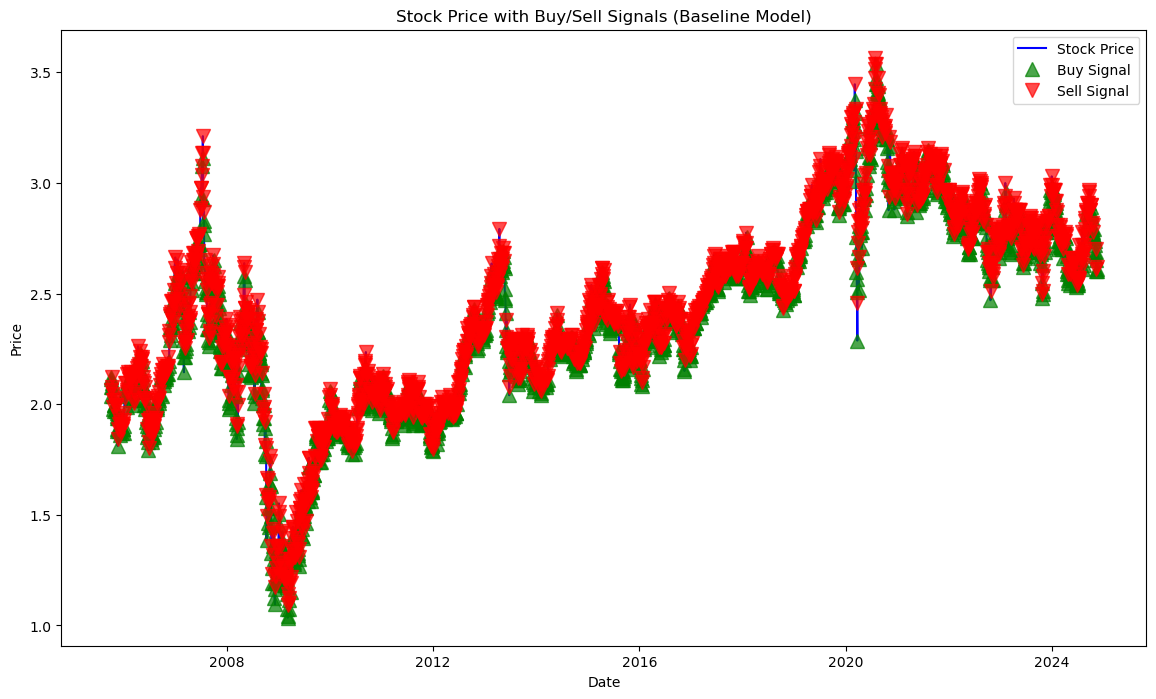

In [70]:
# Plot the closing price
plt.figure(figsize=(14, 8))
plt.plot(df.index, df[('Close', 'A17U.SI')], label='Stock Price', color='blue')

# Plot buy signals
buy_signals = df[df[('Baseline_Signal', '')] == 1]
plt.plot(buy_signals.index, buy_signals[('Close', 'A17U.SI')], '^', markersize=10, color='green', label='Buy Signal', alpha=0.7)

# Plot sell signals
sell_signals = df[df[('Baseline_Signal', '')] == -1]
plt.plot(sell_signals.index, sell_signals[('Close', 'A17U.SI')], 'v', markersize=10, color='red', label='Sell Signal', alpha=0.7)

# Adding labels and title
plt.title('Stock Price with Buy/Sell Signals (Baseline Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show plot
plt.show()

In [124]:
##LSTM - Benchmark Model

In [126]:
df['Price_Diff'] = df['Close'].diff()
df['Volatility'] = df['Close'].rolling(window=10).std()
df['Short_MA'] = df['Close'].rolling(window=10).mean()
df['Long_MA'] = df['Close'].rolling(window=50).mean()

# Drop any rows with NaN values (resulting from the rolling window and differencing)
df.dropna(inplace=True)

# 2. Prepare the Dataset with Selected Features
features = df[['Close', 'Fast_SMA', 'Slow_SMA', 'Volume', 'Price_Diff', 'Volatility']]

# Normalize the data for stability
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [128]:
# 3. Create Sequences for LSTM Input
sequence_length = 30  # Use the last 30 days of data to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Last 30 days of features
    y.append(scaled_features[i, 0])  # Next day's closing price as the target

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# 4. Split the Data into Training and Testing Sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [130]:
# 5. Define the LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Output layer with one unit (predicting the closing price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0199 - val_loss: 0.0029
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.6345e-04 - val_loss: 8.1241e-04
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.1818e-04 - val_loss: 6.5312e-04
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.4399e-04 - val_loss: 5.2133e-04
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.3750e-04 - val_loss: 5.9406e-04
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.0385e-04 - val_loss: 4.9523e-04
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.3599e-04 - val_loss: 4.0843e-04
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.7873e-04 - val_loss: 3.7934e-04
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.6838e-04 - val_loss:

In [132]:
# 7. Make Predictions
y_pred = model.predict(X_test)

# Inverse transform predictions to original scale
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((y_pred, np.zeros((y_pred.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [134]:
# 8. Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 0.03332357080990797, MAE: 0.02533183135364149


In [136]:
# 2. Generate Buy/Sell Signals with Threshold
price_change_threshold = 0.01  # Set a minimum price change threshold to filter minor fluctuations
buy_signals, sell_signals = [], []

In [138]:
for i in range(1, len(y_pred_rescaled)):
    price_diff = y_pred_rescaled[i] - y_test_rescaled[i - 1]
    if price_diff > price_change_threshold:  # Significant increase
        buy_signals.append(y_test_rescaled[i])
        sell_signals.append(np.nan)
    elif price_diff < -price_change_threshold:  # Significant decrease
        sell_signals.append(y_test_rescaled[i])
        buy_signals.append(np.nan)
    else:
        buy_signals.append(np.nan)
        sell_signals.append(np.nan)

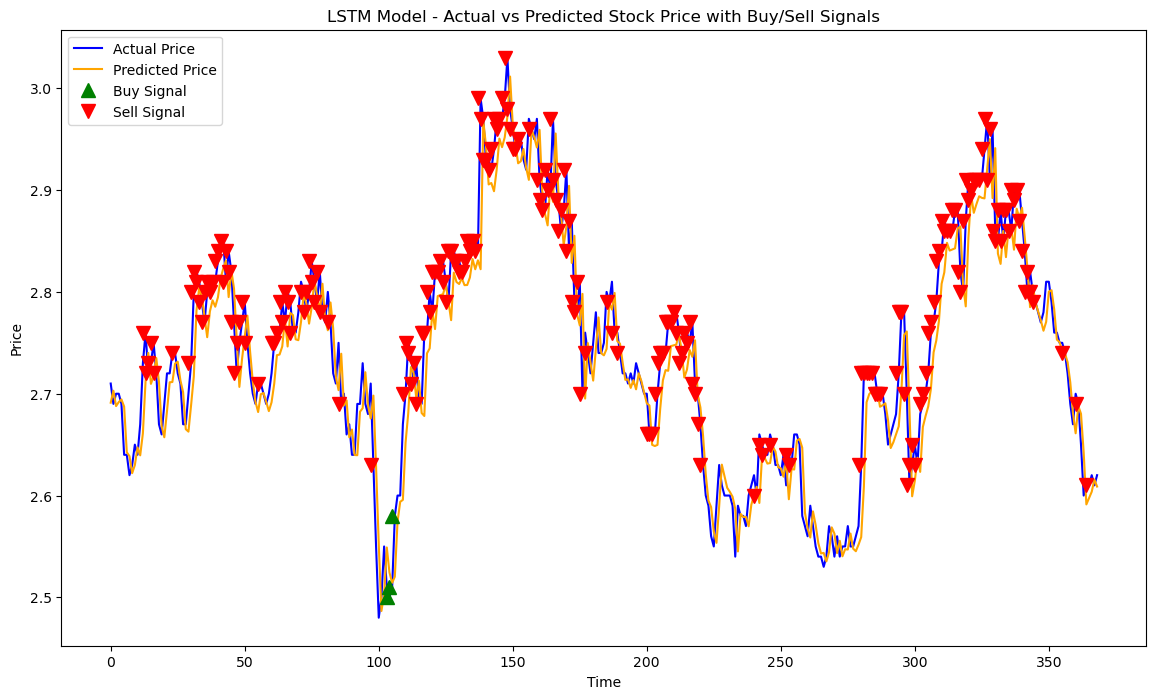

In [140]:
# Plot actual vs predicted price with buy/sell signals
plt.figure(figsize=(14, 8))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Price', color='orange')
plt.plot(buy_signals, marker='^', markersize=10, color='green', linestyle='None', label='Buy Signal')
plt.plot(sell_signals, marker='v', markersize=10, color='red', linestyle='None', label='Sell Signal')
plt.title('LSTM Model - Actual vs Predicted Stock Price with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [142]:
# 3. Computing Portfolio Returns

# Initialize Returns column
transaction_rate = 0.005  # Transaction cost rate (0.5%)
actions = np.zeros(len(y_test_rescaled))
for i in range(1, len(actions)):
    if not np.isnan(buy_signals[i]):
        actions[i] = 1  # Buy
    elif not np.isnan(sell_signals[i]):
        actions[i] = -1  # Sell
    else:
        actions[i] = 0  # Hold

# Calculate portfolio returns based on Equation (1)
returns = [1.0]  # Starting portfolio returns at 1.0 for cumulative product calculation
for i in range(1, len(y_test_rescaled)):
    r_t = (y_test_rescaled[i] / y_test_rescaled[i - 1]) - 1  # Return rate
    action_change = abs(actions[i] - actions[i - 1])  # Change in action to capture transaction cost
    R_t = (1 + actions[i - 1] * r_t) * (1 - transaction_rate * action_change)
    returns.append(returns[-1] * R_t)

IndexError: list index out of range